In [1]:
# Imports

import bmi
import bmi.wrapper
import ipywidgets as widgets
from ipywidgets import HBox, VBox, interactive, Layout, interact
import numpy as np
import logging
import threading
import time

# Something very fishy happening if I don't define a plot first.
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ioff()
_ = plt.figure()
plt.ion()

In [2]:
import sys
import pathlib
import os
mycursuspath = r"C:\Users\backeber\OneDrive - Stichting Deltares\Desktop\To do\todo-0-PAOTM_cursus"
engine = mycursuspath+r"\oss_artifacts_x64_65957\x64\share\bin\dflowfm"
mdufile = mycursuspath+r"\hydrodynamics-course-binder\Workshop 2020\1. Rivers\Models\manning_schematic_river.mdu"

In [3]:
data = []
items = []
wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile);
wrapper.initialize();

In [4]:

parameters = [
    {
        "parameter": "zbndz",
        "slice": [0],
        "description": "Boundary Water level Downstream [m]",
        "default": 4
    },    {
        "parameter": "zbndz",
        "slice": [1],
        "description": "Boundary Water level Upstream [m]",
        "default": 10
    },    {
        "parameter": "frcu",
        "description": "Roughness Chézy",
        "default": str(wrapper.get_var("frcu")[0])
    }
]

In [5]:
# Create widgets
style = {'description_width': 'initial'}

run = widgets.Button(
    description='Run model',
    button_style='',
    icon='play'
)
update = widgets.Button(
    description='Single update',
    button_style='',
    tooltip='Update with 1 timestep',
    icon='step-forward'
)
restart = widgets.Button(
    description='Restart model',
    button_style='',
    tooltip='Restart entire model with initial inputs',
    icon='retweet'
)

settings = widgets.HTML(
    value="Welcome!",
    placeholder='Input settings'
)

play = widgets.Play(
#     interval=10,
    value=0,
    min=0,
    max=int(wrapper.get_end_time()),
    step=1,
    description="Press play",
    disabled=False
)


nsteps = widgets.BoundedIntText(
    description="Number of timesteps",
    value=40,
    min=0,
    max=100,
    style=style,
    layout=Layout(width='15vw')
)

slider = widgets.IntSlider(  
    min=0,
    max=1,
    value=0
)

widgets.jslink((play, 'value'), (slider, 'value'))
player = widgets.HBox([play, slider])

# parameters = ["zbndz", "zbndq", "frcu"]
# p_descrip = ["Boundary Water level", "Boundary Discharge", "Roughness Chézy"]

items=[]
for p in parameters: 
    items.append(widgets.Text(
        description=p["description"],
        disabled=False,
        value=str(p["default"]),
        placeholder=p["parameter"],
        style=style,
        layout=Layout(width='50vw')
    ))

In [6]:
wrapper.get_end_time()

345600.0

In [7]:
# Model specific function 

#     Automate parameter and grid sizes
def update_data():
    waterlevel = wrapper.get_var('s1')[1:-1]
    bedlevel = wrapper.get_var('bl')[1:-1]
    xz = wrapper.get_var('xz')[1:-1]
    data.append(dict({
        "time": wrapper.get_current_time(),
        "waterlevel": waterlevel.copy(), 
        "bedlevel": bedlevel.copy(), 
        "xz": xz.copy()
    }))
    settings.value = "Model update, timestep: {}".format(data[-1]["time"])
update_data()


In [8]:
# Standard functions for button widgets
dostop = False
def update_model(b=None):
#     Update the model with t = 1
    wrapper.update(wrapper.get_time_step())
    if(data[-1]["time"] != wrapper.get_current_time()):
        update_data()

def start_loop(n):
    print(n)
#     Start the loop for running the model continuously
#     while run.value == True: 
    for i in range(n):
        update_model()
        if (wrapper.get_current_time() >= wrapper.get_end_time()):
            stop_model()
            break
        if dostop == True: 
            stop_model()
            break
    stop_model()

def run_model(change=None): 
#     When the run/stop model button is pressed either start the model loop or stop it
    run.disabled = True
    update.disabled = True
    restart.disabled = True
    for i in items:
        i.disabled = True
    start_loop(int(nsteps.value))
#         thread = threading.Thread(target=start_loop)
#         thread.start()

def stop_model(change=None):
    update.disabled = False
    restart.disabled = False
    run.disabled = False
    for i in items:
        i.disabled = False
    dostop = True

def change_param(v):
    try:
        v = v.owner
    except AttributeError: 
        v = v
    if v.value == "":
        return
    
    p = next((x for x in parameters if x['parameter'] == v.placeholder), None)
    try:
        float(v.value)
        old_par = wrapper.get_var(v.placeholder)
        new_par = old_par.copy()
        if ("slice" in p.keys()):
            new_par[p["slice"]] = float(v.value)
        else:
            new_par = new_par * float(v.value)
        wrapper.set_var(v.placeholder, new_par)
        settings.value = "Value ({}) has been set to: {}".format(v.description, new_par[0])
    except ValueError:
        v.value = str(p["default"])
        settings.value = "Not a correct input for {}".format(v.description)

def start_model():
#     start model
    wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile)
    wrapper.initialize()
    update_data()
    for i in range(len(items)): 
        items[i].value = str(wrapper.get_var(parameters[i])[0])
        
def restart_model(b=None):
#     stop the model and call function to restart the model
    del data[:]
    wrapper.finalize()
    start_model()
    settings.value = "Restarting model"

<IPython.core.display.Javascript object>


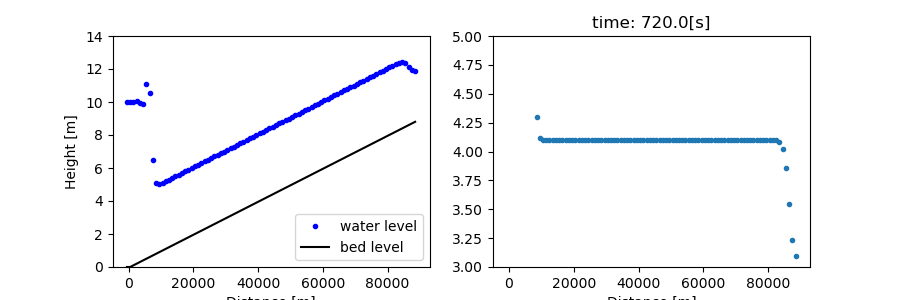

(3, 5)

40


In [9]:
# set plot size
plt.rcParams["figure.figsize"] = (9, 3) # (w, h)

# link functions to widgets
run.on_click(run_model)
update.on_click(update_model)
restart.on_click(restart_model)

def set_plot(change):
    t = change['new']
    if (t < len(data)):
        wlp.set_data(data[t]["xz"], data[t]["waterlevel"])
        blp.set_data(data[t]["xz"], data[t]["bedlevel"])
        wh.set_data(data[t]["xz"], data[t]["waterlevel"] - data[t]["bedlevel"])
        plt.title("time: " + str(data[t]["time"]) + "[s]")
        fig.canvas.draw()
        
player.children[-1].observe(set_plot, 'value')

controls = HBox([run, update, restart])
params = VBox(items)

for i in items: 
    change_param(i)
    i.observe(change_param, names='value')
    
display(VBox([settings, HBox([nsteps, controls]), HBox([params])]))
fig, (ax1, ax2) = plt.subplots(1, 2)
display(player)

wlp, = ax1.plot(data[0]["xz"], data[0]["waterlevel"], ".", color="blue", label="water level")    
blp, = ax1.plot(data[0]["xz"], data[0]["bedlevel"], color="black", label="bed level") 
ax1.set_ylim(0, 14)
ax1.set_xlabel("Distance [m]")
ax1.set_ylabel("Height [m]")
ax1.legend()
plt.title("time: " + str(data[0]["time"]) + "[s]")
wh, = ax2.plot(data[0]["xz"], data[0]["waterlevel"] - data[0]["bedlevel"],'.')
ax2.set_xlabel("Distance [m]")
ax2.set_ylim(3, 5)